# Followed https://en.wikipedia.org/wiki/POVM

In [1]:
%pip install qiskit[visualization]
%pip install qiskit_aer

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [9]:
import numpy as np

In [3]:
def ortho(vector):
  return np.array([np.conj(vector[1]), -np.conj(vector[0])])

In [10]:
# Define computational basis states
zero_ket = np.array([1, 0])
one_ket = np.array([0, 1])
# Define the states phi, psi}to be distinguished
psi = zero_ket
phi = (1 / np.sqrt(2)) * (zero_ket + one_ket)

# ancilla = (0.6 * zero_ket) + (0.8 * one_ket)
# ancilla_ortho = ortho(ancilla)

psi_orthogonal = ortho(psi)
phi_orthogonal = ortho(phi)

phi_psi_bracket = phi.conj().T @ psi

# gamma
c_phi = np.exp(1j * np.angle(phi_psi_bracket))
c_gamma = 1 / np.sqrt(2 * (1 + np.abs(phi_psi_bracket)))
gamma = c_gamma * (psi + (c_phi * phi))

# F_psi
c_F_psi = 1 / (1 + np.abs(phi_psi_bracket))
phi_ortho_outer = np.outer(phi_orthogonal, phi_orthogonal.conj().T)
F_psi = c_F_psi * phi_ortho_outer
f_psi = np.sqrt(c_F_psi) * phi_orthogonal

# F_phi
c_F_phi = 1 / (1 + np.abs(phi_psi_bracket))
psi_ortho_outer = np.outer(psi_orthogonal, psi_orthogonal.conj().T)
F_phi = c_F_phi * psi_ortho_outer
f_phi = np.sqrt(c_F_phi) * psi_orthogonal

# F_unknown
c_F_unknown = (2 * np.abs(phi_psi_bracket)) / (1 + np.abs(phi_psi_bracket))
gamma_outer = np.outer(gamma, gamma.conj().T)
F_unknown = c_F_unknown * gamma_outer
f_unknown = np.sqrt(c_F_unknown) * gamma

f_all_zeros = np.array([0, 0])

oo = np.kron(zero_ket, zero_ket)
oi = np.kron(zero_ket, one_ket)
io = np.kron(one_ket, zero_ket)
ii = np.kron(one_ket, one_ket)

i_s = [oo, oi, io, ii]
f_s = [f_psi, f_phi, f_unknown, f_all_zeros]

V = np.array([np.outer(a, b.conj().T) for a, b in zip(i_s, f_s)]).sum(axis=0)

Q, R = np.linalg.qr(np.array([V @ zero_ket, V @ one_ket, [0, 0, 1, 0], [0, 0, 0, 1]]).T, 'complete')
U = Q * np.sign(np.diag(R))


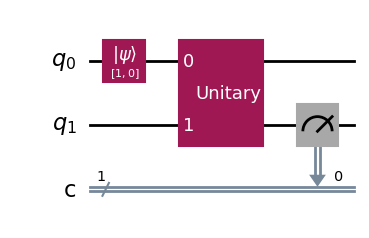

In [5]:
qc = QuantumCircuit(2, 1)
qc.initialize(psi, 0)
qc.unitary(U, [0, 1])
qc.measure(1, 0)
# basis_gates = ['rx', 'ry', 'rz', 'h', 'cx']
# qc = transpile(qc, basis_gates=basis_gates, optimization_level=0)
qc.draw('mpl')

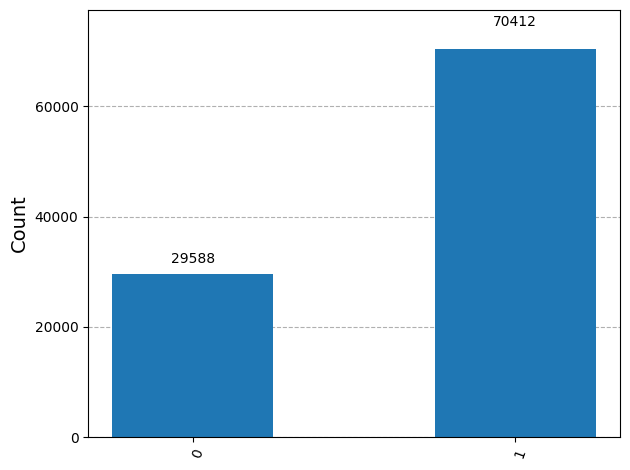

In [6]:
aersim = AerSimulator()
qc = transpile(qc, aersim)
job = aersim.run(qc, shots=100000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [7]:
1 - np.abs(phi_psi_bracket)

np.float64(0.29289321881345254)

In [8]:
1 - np.abs(U[2].conj().T @ np.kron(zero_ket, psi)) ** 2

np.float64(0.2928932188134523)